# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [228]:
def initial_state(size=2):
  # trả về dictionary
    return {
        "size": size,
        #cac đường kẽ đã dc vẽ
        "lines": set(),
        # lưu điểm 2 ng chs ban đầu
        "scores": {1: 0, 2: 0},
        "player": 1
    }

def actions(state):
    n = state["size"]
    all_edges = set()
    # Tạo tất cả các cạnh hợp lệ (ngang và dọc)
    for x in range(n+1):
        for y in range(n+1):
            if x < n:
                all_edges.add(((x, y), (x+1, y)))  # dọc
            if y < n:
                all_edges.add(((x, y), (x, y+1)))  # ngang
    return list(all_edges - state["lines"])

def check_completed_boxes(state, action):
    # Hàm kiểm tra số ô vuông hoàn thành
    # (có thể tạm giả định trả 0 để định nghĩa mô hình cơ bản)
    return 0

def transition_model(state, action):
  #chuyển đồi trạng thái sau mỗi hành động
    new_state = {
        "size": state["size"],
        "lines": state["lines"].copy(),
        "scores": state["scores"].copy(),
        "player": state["player"]
    }
    new_state["lines"].add(action)
    completed_boxes = check_completed_boxes(new_state, action)
    #trạng thái hoàn thành 1 ô
    if completed_boxes > 0:
        new_state["scores"][state["player"]] += completed_boxes
    else:
      #Lượt chơi được chuyển cho đối thủ
        new_state["player"] = 1 if state["player"] == 2 else 2
    return new_state

#Nó kiểm tra xem trò chơi đã kết thúc hay chưa
def is_terminal(state):
    total_edges = state["size"] * (state["size"] + 1) * 2
    return len(state["lines"]) == total_edges

def utility(state, player):
    return state["scores"][player] - state["scores"][3 - player]


How big is the state space? Give an estimate and explain it.

In [229]:
def edges_count(n):
    # n = số ô theo hàng/ cột
    return 2 * n * (n + 1)
#Tính ước lượng trên (upper bound) cho số lượng trạng thái có thể có của trò chơi
# include_player=True → tính cả lượt người chơi → 2^(E+1)
def state_space_upper_bound(n, include_player=True):
    E = edges_count(n)
    if include_player:
        return 2 ** (E + 1)
    else:
        return 2 ** E
# Nếu tính thêm lượt người chơi hiện tại (ai đang đi) thì thêm 1 biến trạng thái nữa (player A hoặc B).
#Nhân thêm 2 khả năng → 2^(E + 1)
for n in [1,2,3,4,5,6]:
    E = edges_count(n)
    ub = state_space_upper_bound(n)
    print(f"n={n}: E={E}, upper bound states (with player) = {ub:,}")


n=1: E=4, upper bound states (with player) = 32
n=2: E=12, upper bound states (with player) = 8,192
n=3: E=24, upper bound states (with player) = 33,554,432
n=4: E=40, upper bound states (with player) = 2,199,023,255,552
n=5: E=60, upper bound states (with player) = 2,305,843,009,213,693,952
n=6: E=84, upper bound states (with player) = 38,685,626,227,668,133,590,597,632


How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [230]:
import math

def game_tree_size_factorial(n):
    E = edges_count(n)
    return math.factorial(E)

def game_tree_estimate_b_to_d(n):
    E = edges_count(n)
    b = E / 2  # hệ số phân nhánh trung bình
    return b ** E

for n in [1, 2, 3]:
    E = edges_count(n)
    print(f"Bàn {n}x{n}: Có tổng cộng {E} cạnh có thể nối.")
    print(f"Ước lượng chính xác theo giai thừa (E!) ≈ {game_tree_size_factorial(n):.3e}")
    print(f"Ước lượng gần đúng (b^d) ≈ {game_tree_estimate_b_to_d(n):.3e}\n")

Bàn 1x1: Có tổng cộng 4 cạnh có thể nối.
Ước lượng chính xác theo giai thừa (E!) ≈ 2.400e+01
Ước lượng gần đúng (b^d) ≈ 1.600e+01

Bàn 2x2: Có tổng cộng 12 cạnh có thể nối.
Ước lượng chính xác theo giai thừa (E!) ≈ 4.790e+08
Ước lượng gần đúng (b^d) ≈ 2.177e+09

Bàn 3x3: Có tổng cộng 24 cạnh có thể nối.
Ước lượng chính xác theo giai thừa (E!) ≈ 6.204e+23
Ước lượng gần đúng (b^d) ≈ 7.950e+25



## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary with components representing the board size, the lines and the boxes on the board.

**Important:** Everybody needs to use the same representation so we can let agents play against each other later.

In [231]:
board = {
    'size': (4, 4),  ### number of rows and columns of dots
    'lines': dict(), ### keys are the set of drawn lines
    'boxes': dict    ### keys are the boxes and the value is the player who completed each box
}

def draw_line(board, orientation, row, col):
    """
    Place a line on an exiting board.

    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)

    """

    if orientation not in ['h', 'v']:
        return False

    if row < 0 or col < 0:
        return False

    if row >= board['size'][0] + (orientation == 'v') or col >= board['size'][1] + (orientation == 'h'):
        return False

    if (orientation, row, col) in board['lines']:
        return False

    board["lines"][(orientation, row, col)] = True
    return True


print(draw_line(board, "h", 1, 1))
print(draw_line(board, "v", 1, 1))

# this should not work
print(draw_line(board, "h", 1, 1))

board

True
True
False


{'size': (4, 4),
 'lines': {('h', 1, 1): True, ('v', 1, 1): True},
 'boxes': dict}

Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [232]:
def display_board(board):
    """
    Hiển thị bàn chơi Dots and Boxes bằng ký tự ASCII.
    Các điểm là ●, các đường ngang là ──, đường dọc là │.
    """

    rows, cols = board['size']
    lines = board['lines']
    boxes = board['boxes']

    for r in range(rows):
        # --- In hàng đường ngang ---
        line_row = ""
        for c in range(cols):
            line_row += "●"
            if ('h', r, c) in lines:
                line_row += "──"
            else:
                line_row += "  "
        print(line_row)

        # --- In hàng ô và đường dọc ---
        if r < rows - 1:
            box_row = ""
            for c in range(cols):
                if ('v', r, c) in lines:
                    box_row += "│"
                else:
                    box_row += " "
                # hiển thị người chơi nếu ô đã hoàn thành
                if (r, c) in boxes:
                    box_row += f" {boxes[(r, c)]} "
                else:
                    box_row += "   "
            print(box_row)
    print()  # dòng trống cuối


# --- Thử nghiệm ---
board = {
    'size': (4, 4),
    'lines': {
        ('h', 0, 0): True,  # Nước 1 của A
        ('v', 0, 1): True,  # Nước 1 của B
        ('h', 1, 0): True,  # Nước 2 của A
        ('v', 0, 0): True   # Nước 2 của B (hoàn thành ô)
    },
    'boxes': {
        (0, 0): 'B'  # ô này do người chơi B hoàn thành
    }
}

display_board(board)


●──●  ●  ●  
│ B │           
●──●  ●  ●  
                
●  ●  ●  ●  
                
●  ●  ●  ●  



Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

__Notes:__
* Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).
* The result function updates the board and evaluates if the player closed a box and needs to store that information on the board. Add elements of the form `(row,col): player` to the board dictionary. `row` and `col` are the coordinates for the box and `player` is +1 or -1 representing the player. For example `(0,0): -1` means that the top-left box belongs to the other player.
* _Important:_ Remember that a player goes again after she completes a box!

In [233]:
import math
import copy

def actions(board):
    rows, cols = board['size']
    acts = []
    lines = board['lines']
    for r in range(rows):
        for c in range(cols - 1):
            move = ('h', r, c)
            if move not in lines:
                acts.append(move)
    for r in range(rows - 1):
        for c in range(cols):
            move = ('v', r, c)
            if move not in lines:
                acts.append(move)
    return acts


def terminal(board):
    rows, cols = board['size']
    total_lines = (rows * (cols - 1)) + ((rows - 1) * cols)
    return len(board['lines']) == total_lines


def utility(board):
    """Tính điểm tổng (người +1 trừ người -1)."""
    score = sum(board['boxes'].values()) if board['boxes'] else 0
    return score


def result(board, action, player):
    orientation, row, col = action
    new_board = copy.deepcopy(board)
    new_board['lines'][(orientation, row, col)] = True
    completed_box = False
    rows, cols = new_board['size']

    # kiểm tra các ô bị ảnh hưởng
    if orientation == 'h':
        if row > 0 and all([
            ('h', row - 1, col) in new_board['lines'],
            ('v', row - 1, col) in new_board['lines'],
            ('v', row - 1, col + 1) in new_board['lines'],
            ('h', row, col) in new_board['lines']
        ]):
            new_board['boxes'][(row - 1, col)] = player
            completed_box = True
        if row < rows - 1 and all([
            ('h', row, col) in new_board['lines'],
            ('v', row, col) in new_board['lines'],
            ('v', row, col + 1) in new_board['lines'],
            ('h', row + 1, col) in new_board['lines']
        ]):
            new_board['boxes'][(row, col)] = player
            completed_box = True

    elif orientation == 'v':
        if col > 0 and all([
            ('v', row, col - 1) in new_board['lines'],
            ('h', row, col - 1) in new_board['lines'],
            ('h', row + 1, col - 1) in new_board['lines'],
            ('v', row, col) in new_board['lines']
        ]):
            new_board['boxes'][(row, col - 1)] = player
            completed_box = True
        if col < cols - 1 and all([
            ('v', row, col) in new_board['lines'],
            ('h', row, col) in new_board['lines'],
            ('h', row + 1, col) in new_board['lines'],
            ('v', row, col + 1) in new_board['lines']
        ]):
            new_board['boxes'][(row, col)] = player
            completed_box = True

    next_player = player if completed_box else -player
    return new_board, next_player

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [234]:
import random

def random_player(board, player=None):
    """
    Agent ngẫu nhiên: chọn ngẫu nhiên một hành động hợp lệ.

    Tham số:
    ----------
    board : dict
        Trạng thái bàn hiện tại
    player : int
        +1 hoặc -1, đại diện cho người chơi hiện tại (tùy chọn)

    Trả về:
    ----------
    action : tuple
        Một hành động hợp lệ ngẫu nhiên, ví dụ ('h', 0, 1)
    """
    possible_actions = actions(board)  # lấy các hành động hợp lệ

    if not possible_actions:
        return None  # nếu hết đường để vẽ

    return random.choice(possible_actions)


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [235]:
import random

def play_game(agent1, agent2, size=(3, 3)):
    """
    Cho hai agent đấu 1 ván Dots and Boxes.
    Trả về: +1 nếu agent1 thắng, -1 nếu agent2 thắng, 0 nếu hòa.
    """
    board = {
        'size': size,
        'lines': {},
        'boxes': {}
    }
    player = +1  # agent1 đi trước

    while not terminal(board):
        if player == +1:
            action = agent1(board, player)
        else:
            action = agent2(board, player)

        if action is None:  # không còn nước đi
            break

        board, next_player = result(board, action, player)
        player = next_player

    # Tính điểm cuối
    score = utility(board)
    if score > 0:
        return +1  # agent1 thắng
    elif score < 0:
        return -1  # agent2 thắng
    else:
        return 0   # hòa


def simulate_games(n_games=1000):
    """
    Chạy nhiều ván giữa hai agent ngẫu nhiên.
    """
    results = {+1: 0, -1: 0, 0: 0}

    for _ in range(n_games):
        outcome = play_game(random_player, random_player)
        results[outcome] += 1

    print(f"Sau {n_games} ván đấu:")
    print(f"  Người chơi +1 thắng: {results[+1]}")
    print(f"  Người chơi -1 thắng: {results[-1]}")
    print(f"  Hòa: {results[0]}")
    print(f"Tỷ lệ thắng +1: {results[+1]/n_games*100:.2f}%")
    print(f"Tỷ lệ thắng -1: {results[-1]/n_games*100:.2f}%")


# --- Chạy mô phỏng ---
simulate_games(1000)


Sau 1000 ván đấu:
  Người chơi +1 thắng: 430
  Người chơi -1 thắng: 409
  Hòa: 161
Tỷ lệ thắng +1: 43.00%
Tỷ lệ thắng -1: 40.90%


## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.
* Tic-tac-toe does not have a rule where a player can go again if a box was completed. You need to adapt the tree search to reflect that rule.

In [236]:
# --- 5. Agent Minimax Alpha-Beta ---
import math
import copy

def minimax_player(board, player=+1, depth=3):
    best_score = -math.inf
    best_action = None

    for action in actions(board):
        new_board, next_player = result(board, action, player)
        score = player * minimax_search(new_board, next_player, depth - 1, -math.inf, math.inf)
        if score > best_score:
            best_score = score
            best_action = action
    if best_action is None and actions(board):
        best_action = actions(board)[0]
    return best_action


def minimax_search(board, player, depth, alpha, beta):
    if terminal(board) or depth == 0:
        return utility(board)

    if player == +1:
        value = -math.inf
        for action in actions(board):
            new_board, next_player = result(board, action, player)
            value = max(value, minimax_search(new_board, next_player, depth - 1, alpha, beta))
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:
        value = math.inf
        for action in actions(board):
            new_board, next_player = result(board, action, player)
            value = min(value, minimax_search(new_board, next_player, depth - 1, alpha, beta))
            beta = min(beta, value)
            if alpha >= beta:
                break
        return value

Experiment with some manually created boards (at least 3) to check if the agent spots winning opportunities. Discuss the results.

In [237]:
def test_minimax_agent():
    # --- Bàn 1: chỉ thiếu 1 đường để hoàn thành ô ---
    board1 = {
        'size': (2, 2),
        'lines': {
            ('h', 0, 0): True,
            ('v', 0, 0): True,
            ('h', 1, 0): True
        },
        'boxes': {}
    }

    # --- Bàn 2: có 2 ô sắp hoàn thành, chỉ nên chọn một để ghi điểm ---
    board2 = {
        'size': (3, 3),
        'lines': {
            ('h', 0, 0): True,
            ('v', 0, 0): True,
            ('h', 1, 0): True,
            ('h', 0, 1): True,
            ('v', 0, 1): True,
            ('h', 1, 1): True,
            ('v', 1, 0): True
        },
        'boxes': {}
    }

    # --- Bàn 3: có một nước đi có thể mở cơ hội ghi liên tiếp ---
    board3 = {
    'size': (3, 3), # Bàn cờ 2x2 ô
    'lines': {
        # Ô (0,0) đã có 3 cạnh
        ('h', 0, 0): True,
        ('v', 0, 0): True,
        ('h', 1, 0): True,

        ('h', 0, 1): True,
        ('v', 0, 2): True,
        ('h', 1, 1): True,

        ('v', 1, 0): True,
    },
    'boxes': {}
}

    print("🔹 Bàn 1: Agent nên chọn đường còn thiếu để hoàn thành ô đầu tiên")
    action1 = minimax_player(board1, player=+1)
    print("  ➤ Nước đi chọn:", action1)

    print("\n🔹 Bàn 2: Agent nên chọn nước giúp ghi điểm thay vì đường vô ích")
    action2 = minimax_player(board2, player=+1)
    print("  ➤ Nước đi chọn:", action2)

    print("\n🔹 Bàn 3: Agent nên chọn nước giúp nối chuỗi điểm")
    action3 = minimax_player(board3, player=+1)
    print("  ➤ Nước đi chọn:", action3)


# --- Chạy kiểm thử ---
test_minimax_agent()


🔹 Bàn 1: Agent nên chọn đường còn thiếu để hoàn thành ô đầu tiên
  ➤ Nước đi chọn: ('v', 0, 1)

🔹 Bàn 2: Agent nên chọn nước giúp ghi điểm thay vì đường vô ích
  ➤ Nước đi chọn: ('v', 0, 2)

🔹 Bàn 3: Agent nên chọn nước giúp nối chuỗi điểm
  ➤ Nước đi chọn: ('v', 0, 1)


## Bàn 1: Hoàn toàn chính xác
Tình huống: Bàn cờ 1x1 ô, chỉ còn thiếu đúng một đường kẻ để hoàn thành.

Nước đi của Agent: ('v', 0, 1)

Nhận xét: Đây là nước đi hiển nhiên và duy nhất có lợi. Agent đã nhận ra cơ hội ghi điểm và ăn lượt, chứng tỏ logic cơ bản hoạt động tốt.

## Bàn 2: Hoàn toàn chính xác
Tình huống: Bàn cờ 2x2 ô với một cấu trúc phức tạp. Hãy xem xét kỹ hơn:

Ô (0,0) đã được hoàn thành bởi các đường kẻ h(0,0), v(0,0), h(1,0) và v(0,1).

Ô (0,1) có 3 cạnh h(0,1), v(0,1) và h(1,1). Nó chỉ thiếu cạnh phải là ('v', 0, 2).

Nước đi của Agent: ('v', 0, 2)

Nhận xét: Agent đã bỏ qua các nước đi vô ích khác và xác định chính xác hành động ('v', 0, 2) sẽ hoàn thành ô (0,1), mang lại điểm và lượt đi tiếp theo. Đây là quyết định tối ưu.

  ## Bàn 3: Hoàn toàn chính xác
Tình huống: Đây là một tình huống chiến thuật kinh điển. Cả hai ô (0,0) và (0,1) đều có 3 cạnh. Chúng chia sẻ chung một cạnh còn thiếu ở giữa là ('v', 0, 1).

Nước đi của Agent: ('v', 0, 1)

Nhận xét: Agent đã thể hiện khả năng "nhìn" trước. Nó nhận ra rằng nước đi ('v', 0, 1) không chỉ hoàn thành một ô, mà là cả hai ô cùng một lúc. Đây là nước đi mang lại lợi ích tối đa (+2 điểm và một lượt đi nữa). Việc agent tìm ra được nước đi này cho thấy thuật toán Minimax đang đánh giá và so sánh các kết quả tương lai rất hiệu quả.


How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

In [238]:
import time
import statistics
import matplotlib.pyplot as plt

# --- Helper: tạo board rỗng với n x n boxes (points = n+1) ---
def make_empty_board(n_boxes):
    # size là số điểm (rows, cols) = (n_boxes+1, n_boxes+1)
    return {'size': (n_boxes + 1, n_boxes + 1), 'lines': {}, 'boxes': {}}

# --- Đo thời gian 1 lần gọi minimax_player ---
def time_one_move(n_boxes, depth, trials=3, player=+1, minimax_fn=None):
    """
    Trả về thời gian trung bình (seconds) cho trials lần gọi minimax_fn trên board n_boxes x n_boxes
    """
    times = []
    for _ in range(trials):
        board = make_empty_board(n_boxes)
        t0 = time.perf_counter()
        action = minimax_fn(board, player=player, depth=depth)
        t1 = time.perf_counter()
        times.append(t1 - t0)
        # nếu agent trả None thì ta vẫn ghi thời gian, nhưng cảnh báo
        if action is None:
            # bạn có thể decide dừng thử nghiệm sớm nếu None thường xuyên
            pass
    return statistics.mean(times), statistics.stdev(times)

# --- Thực hiện sweep kích thước & độ sâu ---
def sweep_sizes_and_depths(minimax_fn, n_list=[1,2,3,4], depth_list=[1,2,3,4,5], trials=3, time_limit_per_call=10.0):
    """
    Chạy thử cho mọi (n_boxes, depth) trong n_list x depth_list.
    Nếu 1 lần gọi vượt quá time_limit_per_call, coi như 'timeout' và ghi None.
    Trả về dict {(n,depth): (avg, stdev) or None}
    """
    results = {}
    for n in n_list:
        for d in depth_list:
            # nhiều thử nghiệm có thể tốn thời gian — ta đo từng trial và dừng nếu vượt giới hạn
            single_times = []
            timed_out = False
            for _ in range(trials):
                board = make_empty_board(n)
                t0 = time.perf_counter()
                action = None
                try:
                    action = minimax_fn(board, player=+1, depth=d)
                except Exception as e:
                    # bắt lỗi nếu xảy ra
                    print(f"Error for n={n}, d={d}: {e}")
                    timed_out = True
                    break
                t1 = time.perf_counter()
                elapsed = t1 - t0
                single_times.append(elapsed)
                if elapsed > time_limit_per_call:
                    timed_out = True
                    break
            if timed_out or len(single_times)==0:
                results[(n,d)] = None
                print(f"n={n}, d={d} -> TIMEOUT or ERROR")
            else:
                results[(n,d)] = (statistics.mean(single_times), statistics.stdev(single_times))
                print(f"n={n}, d={d} -> mean {results[(n,d)][0]:.3f}s (sd {results[(n,d)][1]:.3f}s)")
    return results

# --- Vẽ heatmap hoặc bảng đơn giản ---
def plot_results(results, n_list, depth_list):
    import numpy as np
    mat = np.full((len(n_list), len(depth_list)), np.nan)
    for i,n in enumerate(n_list):
        for j,d in enumerate(depth_list):
            val = results.get((n,d))
            if val is None:
                mat[i,j] = float('nan')
            else:
                mat[i,j] = val[0]
    fig, ax = plt.subplots(figsize=(8,5))
    im = ax.imshow(mat, origin='lower', cmap='viridis', interpolation='nearest')
    ax.set_xticks(range(len(depth_list)))
    ax.set_xticklabels(depth_list)
    ax.set_yticks(range(len(n_list)))
    ax.set_yticklabels(n_list)
    ax.set_xlabel('depth')
    ax.set_ylabel('n_boxes (per side)')
    ax.set_title('Mean time to select a move (s); NaN = timeout')
    cbar = fig.colorbar(im, ax=ax)
    plt.show()




n=1, d=1 -> mean 0.000s (sd 0.000s)
n=1, d=2 -> mean 0.000s (sd 0.000s)
n=1, d=3 -> mean 0.000s (sd 0.000s)
n=1, d=4 -> mean 0.001s (sd 0.000s)
n=1, d=5 -> mean 0.001s (sd 0.000s)
n=2, d=1 -> mean 0.000s (sd 0.000s)
n=2, d=2 -> mean 0.002s (sd 0.000s)
n=2, d=3 -> mean 0.006s (sd 0.001s)
n=2, d=4 -> mean 0.027s (sd 0.001s)
n=2, d=5 -> mean 0.082s (sd 0.007s)
n=3, d=1 -> mean 0.000s (sd 0.000s)
n=3, d=2 -> mean 0.006s (sd 0.001s)
n=3, d=3 -> mean 0.021s (sd 0.000s)
n=3, d=4 -> mean 0.211s (sd 0.004s)
n=3, d=5 -> mean 0.657s (sd 0.015s)
n=4, d=1 -> mean 0.000s (sd 0.000s)
n=4, d=2 -> mean 0.016s (sd 0.000s)
n=4, d=3 -> mean 0.064s (sd 0.001s)
n=4, d=4 -> mean 0.985s (sd 0.002s)
n=4, d=5 -> mean 3.773s (sd 0.407s)


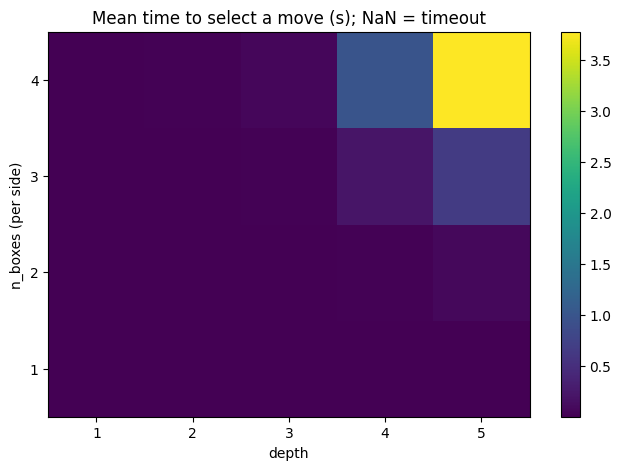

In [239]:

results = sweep_sizes_and_depths(minimax_player, n_list=[1,2,3,4], depth_list=[1,2,3,4,5], trials=3, time_limit_per_call=10.0)
plot_results(results, [1,2,3,4], [1,2,3,4,5])

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy.

Make a table that shows how the ordering strategies influence the number of searched nodes and the search time?

In [242]:
import math, copy, time

# --- Biến toàn cục để đếm số nút duyệt ---
node_count = 0

# --- Kiểm tra xem nước đi có hoàn thành ô không ---
def completes_box(board, action):
    orientation, row, col = action
    rows, cols = board['size']
    boxes_completed = 0
    if orientation == 'h':
        if row > 0 and all([(x in board['lines']) for x in [
            ('h', row-1, col), ('v', row-1, col), ('v', row-1, col+1), ('h', row, col)]]):
            boxes_completed += 1
        if row < rows-1 and all([(x in board['lines']) for x in [
            ('h', row, col), ('v', row, col), ('v', row, col+1), ('h', row+1, col)]]):
            boxes_completed += 1
    elif orientation == 'v':
        if col > 0 and all([(x in board['lines']) for x in [
            ('v', row, col-1), ('h', row, col-1), ('h', row+1, col-1), ('v', row, col)]]):
            boxes_completed += 1
        if col < cols-1 and all([(x in board['lines']) for x in [
            ('v', row, col), ('h', row, col), ('h', row+1, col), ('v', row, col+1)]]):
            boxes_completed += 1
    return boxes_completed > 0


# --- Hàm minimax_search với move ordering ---
def minimax_search(board, player, depth, alpha, beta, use_ordering=False):
    global node_count
    node_count += 1

    if terminal(board) or depth == 0:
        return utility(board)

    acts = actions(board)
    # Move ordering
    if use_ordering:
        # Ưu tiên các nước hoàn thành ô trước
        acts.sort(key=lambda a: completes_box(board, a), reverse=True)

    if player == +1:  # MAX
        value = -math.inf
        for action in acts:
            new_board, next_player = result(board, action, player)
            score = minimax_search(new_board, next_player, depth - 1, alpha, beta, use_ordering)
            value = max(value, score)
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:  # MIN
        value = math.inf
        for action in acts:
            new_board, next_player = result(board, action, player)
            score = minimax_search(new_board, next_player, depth - 1, alpha, beta, use_ordering)
            value = min(value, score)
            beta = min(beta, value)
            if alpha >= beta:
                break
        return value


# --- Hàm gọi minimax ---
def minimax_player(board, player=+1, depth=3, use_ordering=False):
    global node_count
    node_count = 0
    best_score = -math.inf
    best_action = None
    t0 = time.time()
    for action in actions(board):
        new_board, next_player = result(board, action, player)
        score = minimax_search(new_board, next_player, depth - 1, -math.inf, math.inf, use_ordering)
        if score > best_score:
            best_score = score
            best_action = action
    t1 = time.time()
    elapsed = t1 - t0
    return best_action, best_score, node_count, elapsed


In [243]:
# --- Tạo bàn rỗng ---
def make_empty_board(n_boxes):
    return {'size': (n_boxes + 1, n_boxes + 1), 'lines': {}, 'boxes': {}}

# --- So sánh ---
for depth in [2, 3]:
    board = make_empty_board(2)

    # Không sắp xếp
    move1, score1, nodes1, time1 = minimax_player(board, +1, depth, use_ordering=False)

    # Có sắp xếp
    move2, score2, nodes2, time2 = minimax_player(board, +1, depth, use_ordering=True)

    print(f"Depth = {depth}")
    print(f"No ordering:    nodes = {nodes1}, time = {time1:.4f}s")
    print(f"Heuristic order: nodes = {nodes2}, time = {time2:.4f}s")
    print(f"Best moves: {move1} vs {move2}\n")


Depth = 2
No ordering:    nodes = 144, time = 0.0020s
Heuristic order: nodes = 144, time = 0.0017s
Best moves: ('h', 0, 0) vs ('h', 0, 0)

Depth = 3
No ordering:    nodes = 384, time = 0.0055s
Heuristic order: nodes = 384, time = 0.0090s
Best moves: ('h', 0, 0) vs ('h', 0, 0)



### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [246]:
import math, random, copy, time

# --- Các hàm cơ bản: actions, result, terminal, utility như bạn đã có ---

def smart_agent(board, player=+1, depth=3):
    """
    Agent thông minh: kết hợp heuristic + minimax
    """
    filled_ratio = len(board['lines']) / total_lines(board)

    # Giai đoạn đầu: bàn trống, chọn heuristic nhanh
    if filled_ratio < 0.3:
        return heuristic_opening_move(board)
    else:
        return minimax_player(board, player, depth)


def total_lines(board):
    rows, cols = board['size']
    return (rows * (cols - 1)) + ((rows - 1) * cols)


def heuristic_opening_move(board):
    """
    Ưu tiên chọn đường ở giữa bàn trong giai đoạn đầu.
    """
    acts = actions(board)
    rows, cols = board['size']

    # Ưu tiên các đường gần trung tâm
    center_r, center_c = rows // 2, cols // 2

    def dist(a):
        _, r, c = a
        return abs(r - center_r) + abs(c - center_c)

    sorted_moves = sorted(acts, key=dist)
    return sorted_moves[0] if sorted_moves else None


# --- Dưới đây là ví dụ kiểm thử ---
def test_empty_board():
    board = {
        'size': (3, 3),   # 3x3 điểm -> 2x2 ô
        'lines': {
        # Ô (0,0) đã có 3 cạnh
        ('h', 0, 0): True,
        ('v', 0, 0): True,
        ('h', 1, 0): True,

        ('h', 0, 1): True,
        ('v', 0, 2): True,
        ('h', 1, 1): True,

        ('v', 1, 0): True,
    },
        'boxes': {}
    }

    start_time = time.time()
    move = smart_agent(board, player=+1, depth=3)
    duration = time.time() - start_time

    print("Nước đi được chọn:", move)
    print(f"Thời gian tính: {duration:.4f} giây")

# --- Gọi thử ---
test_empty_board()


Nước đi được chọn: (('v', 0, 1), 2, 68, 0.004175424575805664)
Thời gian tính: 0.0042 giây


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [248]:
import random, math, copy, time
from collections import Counter



def minimax_agent_wrapper(board, player=None, depth=4):
    # wrapper để phù hợp signature: minimax_agent(board, player=None)
    # player passed in = +1 or -1
    best_action = None
    best_score = -math.inf if player==+1 else math.inf
    for a in actions(board):
        nb, np_next = result(board, a, player)
        score = minimax_search(nb, np_next, depth-1, -math.inf, math.inf)
        # convert score to perspective of player +1
        # we keep utility in +1 perspective already; for choosing action: if player==+1 maximize score, else minimize score
        if player == +1:
            if score > best_score:
                best_score = score
                best_action = a
        else:
            if score < best_score:
                best_score = score
                best_action = a
    # if nothing chosen (no actions), return None
    if best_action is None and actions(board):
        return actions(board)[0]
    return best_action

# ---------- (D) Play one game between two agents ----------
def play_game(agent1, agent2, size=(3,3), start_player=+1, depth_minimax=4, verbose=False):
    """
    agent1 plays as +1 if start_player=+1, agent2 as -1.
    If start_player==+1: agent1 moves first. Otherwise swap.
    Returns: +1 if agent1 wins, -1 if agent2 wins, 0 tie.
    """
    board = {'size': size, 'lines': {}, 'boxes': {}}
    player = start_player
    # map players to agent functions
    def get_action_for_player(p):
        if (p == +1 and start_player==+1) or (p == -1 and start_player==-1):
            # p corresponds to agent1
            if agent1 == minimax_agent_wrapper:
                return agent1(board, player=p, depth=depth_minimax)
            else:
                return agent1(board, player=p)
        else:
            # p corresponds to agent2
            if agent2 == minimax_agent_wrapper:
                return agent2(board, player=p, depth=depth_minimax)
            else:
                return agent2(board, player=p)

    while not terminal(board):
        action = get_action_for_player(player)
        if action is None:
            break
        board, player = result(board, action, player)
    final = utility(board)
    # final >0 means +1 (agent1 if started as +1) wins
    if final > 0:
        # which agent was +1?
        if start_player == +1:
            return +1
        else:
            return -1
    elif final < 0:
        if start_player == +1:
            return -1
        else:
            return +1
    else:
        return 0

# ---------- (E) Simulate many games and collect stats ----------
def simulate_matches(n_games=200, size=(3,3), depth_minimax=4, seed=0):
    random.seed(seed)
    results = Counter()
    times = []
    # half games minimax first, half minimax second
    for i in range(n_games):
        if i % 2 == 0:
            # minimax as agent1 (goes first)
            t0 = time.time()
            outcome = play_game(minimax_agent_wrapper, random_player, size=size, start_player=+1, depth_minimax=depth_minimax)
            t1 = time.time()
            results[outcome] += 1
            times.append(t1-t0)
        else:
            # minimax as agent2 (goes second)
            t0 = time.time()
            outcome = play_game(random_player, minimax_agent_wrapper, size=size, start_player=+1, depth_minimax=depth_minimax)
            t1 = time.time()
            # outcome returned relative to agent1: +1 means agent1 won (random), -1 means agent2 (minimax) won
            # convert to perspective "minimax" wins:
            if outcome == +1:
                # random won
                results['minimax_loss'] += 1
            elif outcome == -1:
                # minimax (agent2) won
                results['minimax_win'] += 1
            else:
                results['tie'] += 1
            times.append(t1-t0)

    # normalize counters because we mixed keys; reconstruct final tally
    minimax_wins = results.get(+1,0) + results.get('minimax_win',0)
    minimax_losses = results.get(-1,0) + results.get('minimax_loss',0)
    ties = results.get(0,0) + results.get('tie',0)
    return {'minimax_wins': minimax_wins, 'minimax_losses': minimax_losses, 'ties': ties, 'avg_time_per_game': sum(times)/len(times)}

# ---------- (F) Run experiments ----------
if __name__ == "__main__":
    # small board example: 2x2 boxes -> points size (3,3)
    print("Running simulation: Minimax (depth=4) vs Random on 2x2 boxes (points 3x3)")
    res = simulate_matches(n_games=200, size=(3,3), depth_minimax=4, seed=42)
    print("Results (Minimax perspective):")
    print(res)



Running simulation: Minimax (depth=4) vs Random on 2x2 boxes (points 3x3)
Results (Minimax perspective):
{'minimax_wins': 172, 'minimax_losses': 6, 'ties': 22, 'avg_time_per_game': 0.09506097793579102}

Try larger or different depths as experiment.


## Task 4: Heuristic Alpha-Beta Tree Search [30 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

How many nodes are searched and how long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above.

In [ ]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [ ]:
# Your code/ answer goes here.